<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/project-crypto-group16/blob/main/covid_influxdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 3.0MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
from datetime import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [3]:
#ensure client object is not null. this will only happen if the connection succeeded.
passwd=getpass('Enter Password Here:')
client = InfluxDBClient(host='3.85.177.70', username='admin', password='dudgus06', port=8086, database="covid")

Enter Password Here:··········


In [4]:
# Assuming you have created the energy database through influxd CLI. 
# Now, test the connection status...
print('existing databases:', client.get_list_database())

# create an example database
client.create_database('example')
print('existing databases:', client.get_list_database())

# delete the example database
client.drop_database('example')
print('existing databases:', client.get_list_database())


existing databases: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}]
existing databases: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}, {'name': 'example'}]
existing databases: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}]


# Load COVID-19 data to influxDB

In [ ]:
# 88282 rows x 7 columns
# took about 10-30mins to write to influxdb client

def load_data():
    df = pd.read_csv('worldometer_coronavirus_daily_data.csv')
    c = pd.read_csv('worldometer_coronavirus_summary_data.csv')
    c = c.set_index('country')
    # data preprocessing
    # nan values caused invalid number error so need to replace with 0
    df = df.fillna(0)
    json_body = []
    count = 0
    for index, row in df.iterrows():
      try:
        json_body.append(
          {
            "measurement": "covid",
            "tags": {
                "continent": c["continent"][row["country"]]
            },
            "time": row["date"],
            "fields": {
                "country": row["country"],
                "cumulative_total_cases": row["cumulative_total_cases"],
                "daily_new_cases": row["daily_new_cases"],
                "active_cases": row["active_cases"],
                "cumulative_total_deaths": row["cumulative_total_deaths"],
                "daily_new_deaths": row["daily_new_deaths"]
            }
          })
        count += 1
      # print error if occurs
      except Exception as e: 
        print(e)
        pass
      if count % 10000 == 0:
        client.write_points(json_body)
        count = 0
        json_body = []

    client.write_points(json_body)
    print('finished loading data for covid dataset')

load_data()    

finished loading data for covid dataset


# Query 3
Plot COVID cumulative total cases using monthly averages of each continent. This will produce 6 plots (NA, SA, Africa, Europe, Asia, Australia)

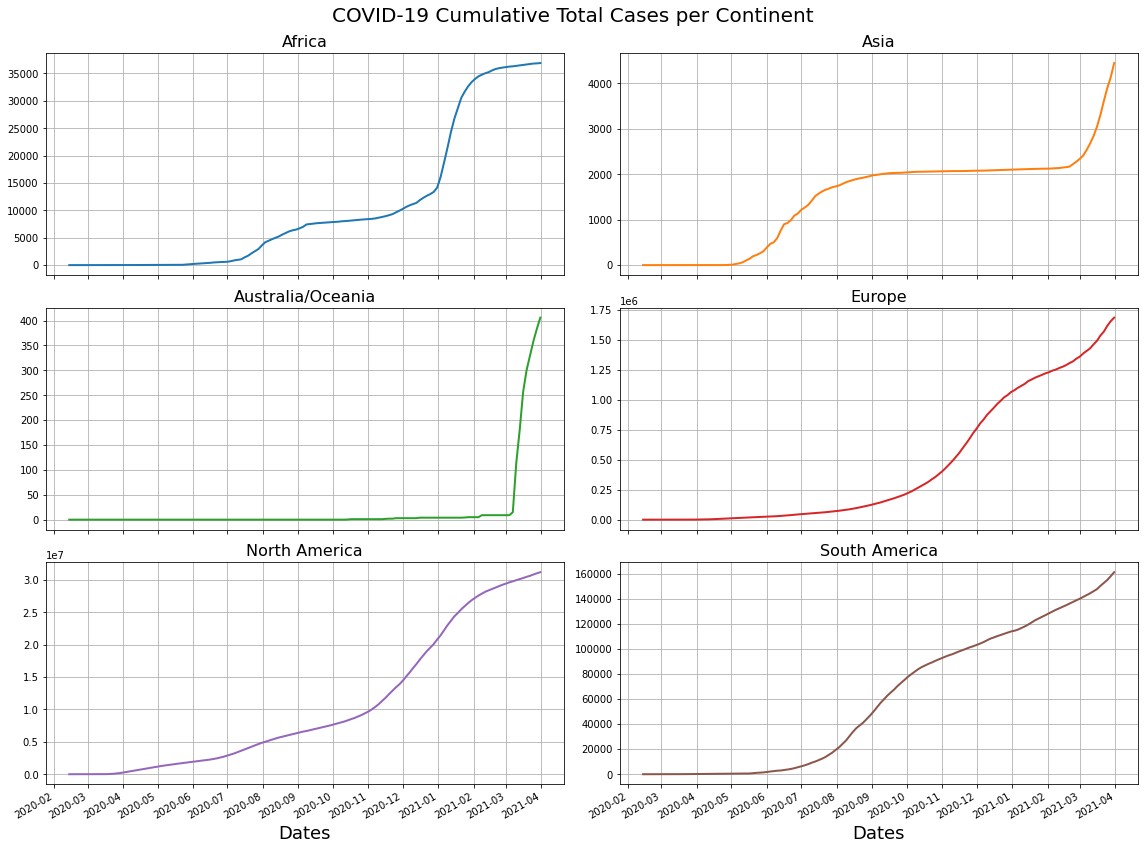

In [19]:
def cumulative_plots():
    continents = ['Africa', 'Asia', 'Australia/Oceania', 'Europe', 'North America', 'South America']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    fig, axs = plt.subplots(3,2, sharex=True, sharey=False, figsize=(16,12))
    fig.suptitle('COVID-19 Cumulative Total Cases per Continent', fontsize = 20)
    
    for i in range(len(continents)):
      query_str = 'SELECT mean("cumulative_total_cases") FROM covid WHERE time > \'2020-02-15T00:00:00Z\' AND time < \'2021-04-02T00:00:00Z\' AND "continent"=\'{}\' GROUP BY time(3d) FILL(null)'.format(continents[i])
      try:
        result = list(client.query(query_str).get_points('covid'))
      except Exception as e:
        print(e)

      timesteps = [datetime.strptime(r['time'][:10], '%Y-%m-%d') for r in result]
      daily = [round(r['mean'], 2) for r in result]

      posx = int(i/2)
      posy = int(i%2)

      axs[posx][posy].plot(timesteps, daily, color = colors[i], linewidth = 2)
      axs[posx][posy].set_title(continents[i], fontsize = 16)

      fmt_month = mdates.MonthLocator(interval=1)
      axs[posx][posy].xaxis.set_major_locator(fmt_month)
      axs[posx][posy].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
      axs[posx][posy].format_xdata = mdates.DateFormatter('%Y-%m')
      axs[posx][posy].grid(True)

    fig.autofmt_xdate()
    for ax in axs[2]:
      ax.set_xlabel("Dates", fontsize = 18) 
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # uncomment to save image file
    #plt.savefig("cumulative_per_continent.png")

cumulative_plots()

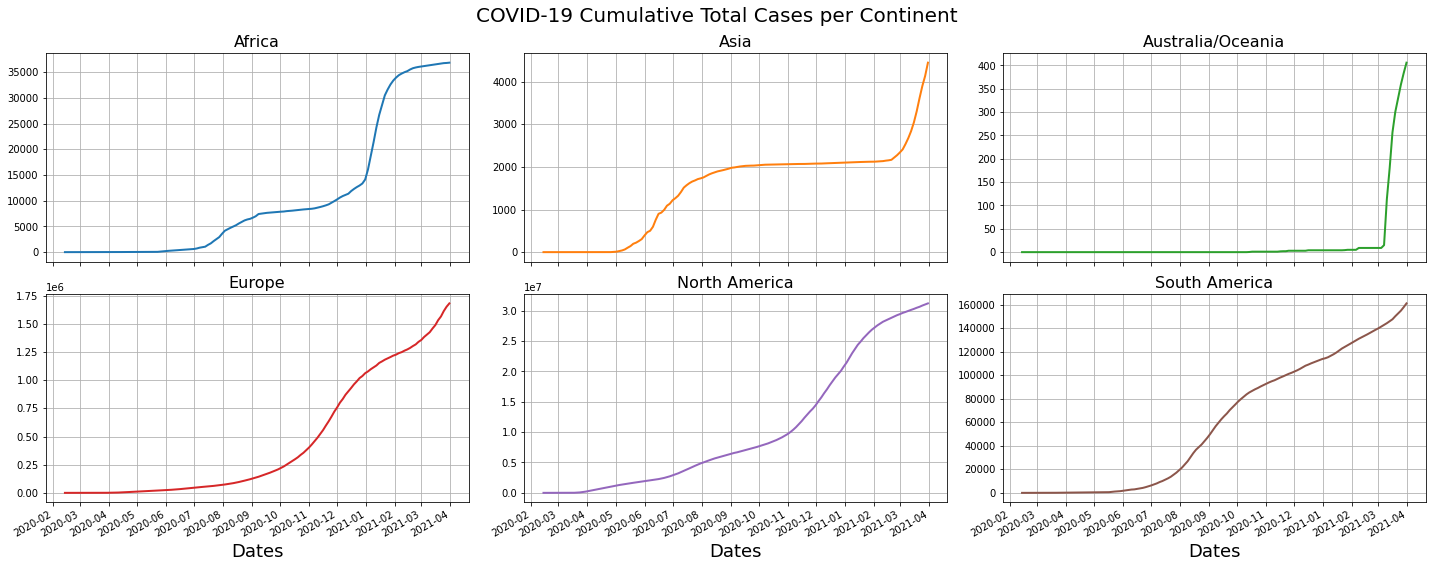

In [23]:
def cumulative_plots2():
    continents = ['Africa', 'Asia', 'Australia/Oceania', 'Europe', 'North America', 'South America']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    fig, axs = plt.subplots(2,3, sharex=True, sharey=False, figsize=(20,8))
    fig.suptitle('COVID-19 Cumulative Total Cases per Continent', fontsize = 20)
    
    for i in range(len(continents)):
      query_str = 'SELECT mean("cumulative_total_cases") FROM covid WHERE time > \'2020-02-15T00:00:00Z\' AND time < \'2021-04-02T00:00:00Z\' AND "continent"=\'{}\' GROUP BY time(3d) FILL(null)'.format(continents[i])
      try:
        result = list(client.query(query_str).get_points('covid'))
      except Exception as e:
        print(e)

      timesteps = [datetime.strptime(r['time'][:10], '%Y-%m-%d') for r in result]
      daily = [round(r['mean'], 2) for r in result]

      posx = int(i/3)
      posy = int(i%3)

      axs[posx][posy].plot(timesteps, daily, color = colors[i], linewidth = 2)
      axs[posx][posy].set_title(continents[i], fontsize = 16)

      fmt_month = mdates.MonthLocator(interval=1)
      axs[posx][posy].xaxis.set_major_locator(fmt_month)

      axs[posx][posy].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

      axs[posx][posy].format_xdata = mdates.DateFormatter('%Y-%m')
      axs[posx][posy].grid(True)

    fig.autofmt_xdate()
    for ax in axs[1]:
      ax.set_xlabel("Dates", fontsize = 18) 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # uncomment to save image file
    #plt.savefig("cumulative_per_continent2.png")

cumulative_plots2()